In [1]:
import warnings
import numpy as np 
import matplotlib.pyplot as plt 
import utils
import metric 
import torch 
import dataloader 
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
import segmentation_models_pytorch as smp
from torchsummary import summary
import time
import math 
import pandas as pd 
import wandb
from tqdm import tqdm
from torch import nn

In [2]:
# hyperparams
batch_size = 16
patch_size = (512, 512)
encoder_model = 'resnet18'
n_class = 1
test_fol = 'testB_ds'
weight_path = 'weights/best_weight.pth'

In [3]:
warnings.filterwarnings('ignore')
tabular_data = pd.read_csv('data.csv')
ds_dict = dataloader.get_split_fold(tabular_data)
val_dl = dataloader.DataLoader(data=ds_dict[test_fol], batch_size=batch_size, patch_size=patch_size,
                               num_threads_in_multithreaded=1, seed_for_shuffle=5243,
                               return_incomplete=True, shuffle=False, infinite=False)
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
# define model
model = smp.Unet(encoder_name=encoder_model, decoder_use_batchnorm=True,
                 in_channels=3, classes=n_class).to(device)

In [4]:
summary(model, (3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 512, 512]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 128, 128]        --
|    └─Sequential: 2-5                   [-1, 64, 128, 128]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 128, 128]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 128, 128]        73,984
|    └─Sequential: 2-6                   [-1, 128, 64, 64]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 64, 64]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 64, 64]         295,424
|    └─Sequential: 2-7                   [-1, 256, 32, 32]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 32, 32]     

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 512, 512]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 128, 128]        --
|    └─Sequential: 2-5                   [-1, 64, 128, 128]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 128, 128]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 128, 128]        73,984
|    └─Sequential: 2-6                   [-1, 128, 64, 64]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 64, 64]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 64, 64]         295,424
|    └─Sequential: 2-7                   [-1, 256, 32, 32]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 32, 32]     

In [5]:
# xent = nn.BCELoss()
dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
# label smoothing
xent = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)

def custom_loss(pred, target):
    xent_l = xent(pred, target)
    dice_l = dice_loss(pred, target)
    loss = xent_l + dice_l
    return loss, xent_l, dice_l

def test(model):
    num_batches = math.ceil(len(ds_dict[test_fol]['img_npy']) / batch_size)
    model.eval()
    test_loss, correct = 0, 0
    # no need back prop for testing set
    batch_xent_l = []
    batch_dice_l = []
    batch_loss = []
    imgs_list = []
    segs_list = []
    pred_list = []
    segs_ori_list = []
    print("Testing...")
    with torch.no_grad():
        for i in tqdm(range(num_batches)):
            val_batch = next(val_dl)
            imgs = val_batch['data']
            segs = val_batch['seg']
            segs_ori = segs 
            # normalization
            imgs = utils.min_max_norm(imgs)
            # binarisation
            segs = np.where(segs > 0., 1.0, 0.).astype('float32')
            segs = np.expand_dims(segs[:, 0, :, :], 1)
            imgs, segs = torch.from_numpy(imgs).to(device), torch.from_numpy(segs).to(device)
            # Compute loss
            pred = model(imgs)
            loss, xent_l, dice_l = custom_loss(pred, segs)
            # batch losses
            batch_xent_l.append(xent_l)
            batch_dice_l.append(dice_l)
            batch_loss.append(loss)
            imgs_list.append(imgs.cpu().detach().numpy())
            segs_list.append(segs.cpu().detach().numpy())
            pred_list.append(pred.cpu().detach().numpy())
            segs_ori_list.append(segs_ori)
        # apply sigmoid to masking
        segs = nn.Sigmoid()(segs)
        # taking the average along the batch
        loss = torch.mean(torch.as_tensor(batch_loss)).item()
        avg_xent_l = torch.mean(torch.as_tensor(batch_xent_l)).item()
        avg_dice_l = torch.mean(torch.as_tensor(batch_dice_l)).item()
    return {'loss': loss, 'xent_l': avg_xent_l, 'dice_l': avg_dice_l,
            'imgs': imgs_list,
            'segs': segs_list,
            'pred': pred_list,
            'segs_ori': segs_ori_list
            }

In [6]:
model.load_state_dict(torch.load(weight_path))
start = time.time()
test_output = test(model)
print("Runtime: {} s".format(time.time()-start))
print("Total loss: {:.2f}, BCE: {:.2f}, Dice Score: {:2f}".format(test_output['loss'], 
    test_output['xent_l'], 1-test_output['dice_l']))

  0%|          | 0/2 [00:00<?, ?it/s]

Testing...


100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

Runtime: 0.38131141662597656 s
Total loss: 0.69, BCE: 0.55, Dice Score: 0.865188


In [8]:
swap = (lambda x: np.einsum('bchw->bhwc', x))
repeat_channel = (lambda x: np.repeat(x, 3, axis=-1))
# stack the image along the batch axis 
total_segs = swap(np.vstack(tuple(test_output['segs_ori'])))
total_imgs = swap(np.vstack(tuple(test_output['imgs'])))
total_pred = repeat_channel(swap(np.where(np.vstack(tuple(test_output['pred']))>0.5, 1.0, 0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


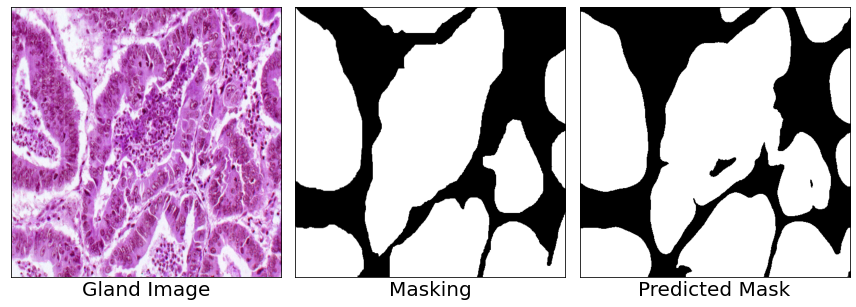

In [9]:
# sanity check for predicted output 
imgs = [total_imgs[1], total_segs[1], total_pred[1]]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)

In [10]:
# convert binary segmentation to gland-level label
pred_multi = np.where((total_segs>0.) & (total_pred==1.0), total_segs, 0.0)

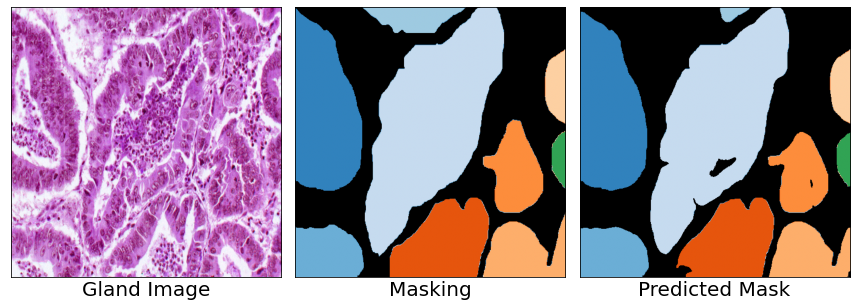

In [19]:
seg_color = utils.plot_labels_color(total_segs[1].astype('uint8'))
pred_color = utils.plot_labels_color(pred_multi[1].astype('uint8'))
imgs = [total_imgs[1], seg_color, pred_color]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)

In [28]:
# dice obj
dice_list = []
for i in range(len(total_segs)):
    obj_dice = metric.ObjectDice(pred_multi[i], total_segs[i])
    dice_list.append(obj_dice)
print(np.mean(dice_list))

0.9621242101163489


In [27]:
# F1 score
f1_score = metric.F1score(total_segs, pred_multi)
print(f1_score)

1.0
